In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

      N   T  MSE  STD
0   117   4  0.0  0.0
1    10   5  0.0  0.0
2   128   1  0.0  0.0
3    83  10  0.0  0.0
4   109   5  0.0  0.0
5    90   0  0.0  0.0
6    82   2  0.0  0.0
7   148   4  0.0  0.0
8   184   3  0.0  0.0
9    69   3  0.0  0.0
10  108   4  0.0  0.0
11  102   9  0.0  0.0
12   12  11  0.0  0.0
13  177   3  0.0  0.0
14   44   6  0.0  0.0
15   88  10  0.0  0.0
16   49   8  0.0  0.0
17   48   5  0.0  0.0
18   10   9  0.0  0.0
19   41   5  0.0  0.0
{'T_Max': 12, 'proc': 3, 'Searches': 10, 'reps': 50, 'Y': 'co2_flux', 'epochs': 1000, 'N_Max': 200}


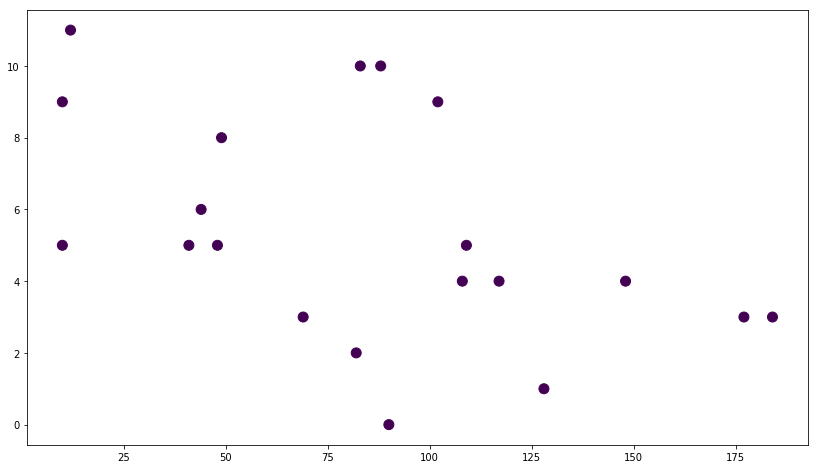

In [2]:
class Params:
    def __init__(self,Func,Y):
        if Func == 'Full':
            epochs = 1000
            reps = 50
            N_Max = 200
            T_Max = 12
            samp_size = 20
            Searches = 10
        else:
            epochs = 10
            reps = 9
            N_Max = 100
            T_Max = 5
            samp_size = 5
            Searches = 2
        N = np.array(np.random.rand(samp_size)*(N_Max-1)+1,dtype='int32')
        T = np.array(np.random.rand(samp_size)*T_Max,dtype='int32')
        d = {'N':N,'T':T}
        self.Runs = pd.DataFrame(data=d)
        self.params = {}
        self.params['T_Max'] = T_Max
        self.params['N_Max'] = N_Max
        self.params['reps'] = reps
        self.params['epochs'] = epochs
        self.params['Y'] = Y
        self.params['proc']=3
        self.params['Searches']=Searches

rpms = Params('Full','co2_flux')
# rpms = Params('Test',5,'ch4_flux')
Runs,params = rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

In [3]:
class ReadStandardTime:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        
    def Scale(self,y_var,X_vars):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        X = self.Data[X_vars]
        self.input_shape = len(X_vars)
        XStandard = StandardScaler()
        self.XScaled= XStandard.fit(X)
        self.X = self.XScaled.transform(X)
        Filling = self.Master[X_vars]
        Filling = Filling.interpolate().bfill()
        Filling = Filling.interpolate().ffill()
        XStandard = StandardScaler()
        self.XFillScaled= XStandard.fit(Filling)
        self.X_fill = self.XScaled.transform(Filling)
        
    def TimeShape(self,rolls):
        X1 = self.X
        Xf = self.X_fill
        self.X_time = np.zeros(shape = (X1.shape[0],rolls+1,X1.shape[1]))
        self.X_time[:,0,:] = X1
        self.X_ftime = np.zeros(shape = (Xf.shape[0],rolls+1,Xf.shape[1]))
        self.X_ftime[:,0,:] = Xf
        if rolls > 0:
            for roll in range(0,rolls):
                X2 = np.roll(X1,(roll+1),axis=0)
                X2f = np.roll(Xf,(roll+1),axis=0)
                self.X_time[:,roll+1,:] = X2
                self.X_ftime[:,roll+1,:] = Xf
        self.X_time = self.X_time[rolls+1:,:,:]
        self.X_ftime = self.X_ftime[rolls+1:,:,:]
        self.y_time = self.y[rolls+1:]
        self.y_ftime = self.y[rolls+1:]
        self.TimeSteps = rolls+1
        
    def Fill(self,Y_Pred):
        Y_fill = self.YScaled.inverse_transform(Y_Pred.reshape(-1,1))
        nanz = np.zeros(shape=(self.TimeSteps,1))
        nanz[:,:] = np.nan
        Y_Pred = np.concatenate((nanz,Y_fill),axis=0).reshape(-1,1)
        self.Master['TempFIll'] = Y_Pred
        self.Master[self.y_var+'_Filled'] = self.Master[self.y_var].fillna(self.Master['TempFIll'])

In [4]:
def LSTM_Model(Neurons,batch_size,time_steps,inputs,lr=1e-4,Memory=.9):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
#     from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = Memory
    session = tf.Session(config=config)
    model = Sequential()
    model.add(LSTM(Neurons, input_shape=(time_steps,inputs),stateful = False))
    model.add(Dense(1))
    NUM_GPU = 1 # or the number of GPUs available on your machine
    
    adam = keras.optimizers.Adam(lr = lr)
    gpu_list = []
    for i in range(NUM_GPU): gpu_list.append('gpu(%d)' % i)
    model.compile(loss='mean_squared_error', optimizer='adam')#,context=gpu_list) # - Add if using MXNET
    return(model)

def Train_Steps(epochs,Neurons,X_train,X_test,X_val,y_train,y_test,y_val,i,Memory=None):
    
    np.random.seed(i)
    from keras import backend as K
#     epochs = 100
    Scorez=[]
    lr = 1e-3
    Mod = LSTM_Model(Neurons,X_train.shape[0],X_train.shape[1],X_train.shape[2],lr=lr,Memory=Memory)
    killscore=0
    killmax = 10
    e = 0
    udate = 3
    while killscore < killmax and e < epochs:
        Mod.fit(X_train,y_train,batch_size=X_train.shape[0], nb_epoch=1,shuffle=True,verbose=0)
        old_weights = Mod.get_weights()
        Y = Mod.predict(X_test,batch_size =X_test.shape[0])
        score = metrics.mean_squared_error(y_test,Y)
        Scorez.append(score)
        if e == 0:
            score_min=score
            min_weights=old_weights
        elif score < score_min:
            score_min = score
            min_weights=old_weights
            killscore = 0
        else:
            killscore +=1
        if killscore == math.floor(killmax/2):
            K.set_value(Mod.optimizer.lr, 0.5 * K.get_value(Mod.optimizer.lr))
        Mod.reset_states()
        e +=1
    Mod.set_weights(min_weights)
    Yval = Mod.predict(X_val,batch_size = X_val.shape[0])
    MSE = (metrics.mean_squared_error(y_val,Yval))
    Scorez=np.asanyarray(Scorez)
    return(MSE)
           

In [5]:
def TTV_Split(i,Memory,X,y,params):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,y_val,i=i,Memory=Memory))

# Model = ['Temp_2_5_1','u*','air_pressure','Table_1']#,'NR_Wm2_Avg','AirTC_Avg','RH','DOY']

Model = ["DOY","H","air_pressure","wind_speed","wind_dir","u*","Hz","AirTC_Avg","RH_Samp","Rain_mm_Tot","NR_Wm2_Avg",
         "PPFD_Avg","Temp_2_5_1","Temp_15_1","Temp_5_1","Temp_2_5_2","Temp_15_2","Temp_5_2","Depth_1","Active_Layer_1",
         "Table_1","Depth_2","Active_Layer_2"]



Time = time.time()

Path = 'FI_Data.csv' 
def RunReps(Model,Runs,params,pool = None):
    RST = ReadStandardTime(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    MSE = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,mse in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params),range(params['reps']))):
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            mse = TTV_Split(i,Memory,X,y,params)
            MSE.append(mse)
    MSE = np.asanyarray(MSE)
    return(MSE)
    

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    

for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehd Run ',str(i))
    print(' Stats: ')
    print(Runs.iloc[i])

print(Runs)
  
print(time.time()-Time)
        

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  0
 Stats: 
N      117.000000
T        4.000000
MSE      0.065245
STD      0.009405
Name: 0, dtype: float64
Finisehd Run  1
 Stats: 
N      10.000000
T       5.000000
MSE     0.094685
STD     0.012523
Name: 1, dtype: float64
Finisehd Run  2
 Stats: 
N      128.000000
T        1.000000
MSE      0.063638
STD      0.009636
Name: 2, dtype: float64
Finisehd Run  3
 Stats: 
N      83.000000
T      10.000000
MSE     0.081253
STD     0.013779
Name: 3, dtype: float64


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  4
 Stats: 
N      109.000000
T        5.000000
MSE      0.072825
STD      0.011184
Name: 4, dtype: float64
Finisehd Run  5
 Stats: 
N      90.000000
T       0.000000
MSE     0.065068
STD     0.009467
Name: 5, dtype: float64
Finisehd Run  6
 Stats: 
N      82.000000
T       2.000000
MSE     0.061422
STD     0.010390
Name: 6, dtype: float64
Finisehd Run  7
 Stats: 
N      148.000000
T        4.000000
MSE      0.065598
STD      0.010607
Name: 7, dtype: float64


Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  8
 Stats: 
N      184.000000
T        3.000000
MSE      0.066187
STD      0.010960
Name: 8, dtype: float64


Using TensorFlow backend.


Finisehd Run  9
 Stats: 
N      69.000000
T       3.000000
MSE     0.069320
STD     0.010614
Name: 9, dtype: float64
Finisehd Run  10
 Stats: 
N      108.000000
T        4.000000
MSE      0.066769
STD      0.009467
Name: 10, dtype: float64
Finisehd Run  11
 Stats: 
N      102.000000
T        9.000000
MSE      0.083444
STD      0.014506
Name: 11, dtype: float64
Finisehd Run  12
 Stats: 
N      12.000000
T      11.000000
MSE     0.118913
STD     0.034688
Name: 12, dtype: float64


Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  13
 Stats: 
N      177.000000
T        3.000000
MSE      0.066125
STD      0.010022
Name: 13, dtype: float64
Finisehd Run  14
 Stats: 
N      44.000000
T       6.000000
MSE     0.080583
STD     0.011535
Name: 14, dtype: float64
Finisehd Run  15
 Stats: 
N      88.000000
T      10.000000
MSE     0.084324
STD     0.016430
Name: 15, dtype: float64
Finisehd Run  16
 Stats: 
N      49.000000
T       8.000000
MSE     0.083048
STD     0.011125
Name: 16, dtype: float64


Using TensorFlow backend.


Finisehd Run  17
 Stats: 
N      48.000000
T       5.000000
MSE     0.076169
STD     0.010455
Name: 17, dtype: float64


Using TensorFlow backend.
Using TensorFlow backend.


Finisehd Run  18
 Stats: 
N      10.000000
T       9.000000
MSE     0.111022
STD     0.026052
Name: 18, dtype: float64
Finisehd Run  19
 Stats: 
N      41.000000
T       5.000000
MSE     0.075892
STD     0.011769
Name: 19, dtype: float64
      N   T       MSE       STD
0   117   4  0.065245  0.009405
1    10   5  0.094685  0.012523
2   128   1  0.063638  0.009636
3    83  10  0.081253  0.013779
4   109   5  0.072825  0.011184
5    90   0  0.065068  0.009467
6    82   2  0.061422  0.010390
7   148   4  0.065598  0.010607
8   184   3  0.066187  0.010960
9    69   3  0.069320  0.010614
10  108   4  0.066769  0.009467
11  102   9  0.083444  0.014506
12   12  11  0.118913  0.034688
13  177   3  0.066125  0.010022
14   44   6  0.080583  0.011535
15   88  10  0.084324  0.016430
16   49   8  0.083048  0.011125
17   48   5  0.076169  0.010455
18   10   9  0.111022  0.026052
19   41   5  0.075892  0.011769
12290.622340917587


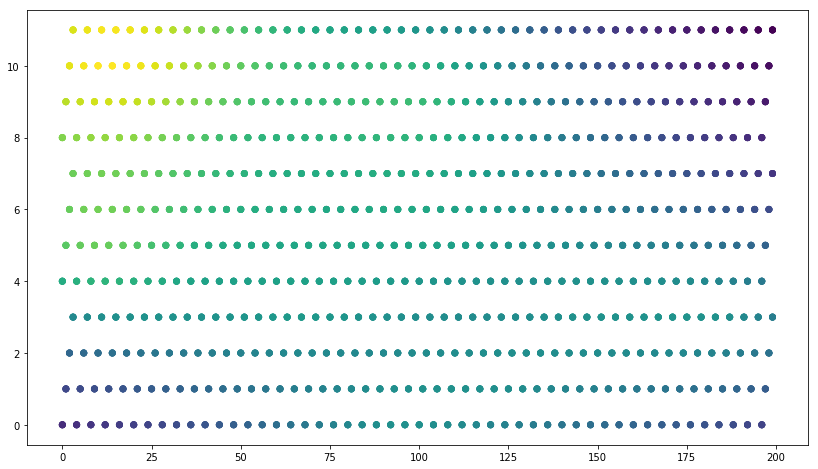

In [6]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (14, 8)
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel = Matern(length_scale = [50,3],length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=0,normalize_y=False)
gp.fit(Runs[['N','T']].values, Runs['MSE'].values)


N = [n for n in range(params['N_Max'])]
T = [t for t in range(params['T_Max'])]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[i] for j in range(len(T))for i in range(len(N))]
T = np.asanyarray(A)
N = np.asanyarray(B)

X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T
y_pred,sigma = gp.predict(X,return_std=True)

plt.figure()
plt.scatter(X[:,0],X[:,1],c=y_pred)
plt.legend()
Runs2 = Runs.copy()

In [7]:
from scipy.optimize import minimize
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

[ 85.49486845   1.13059913]
85 1
[ 0.06097487  0.09076438  0.06289453  0.07541423  0.08710048  0.07843209
  0.10385881  0.07137604  0.08671309  0.06580129  0.0713359   0.06800223
  0.10370354  0.06735102  0.09423625  0.09735889  0.08139642  0.07029984
  0.07173304  0.08634539  0.07304135  0.06262455  0.08283594  0.07458182
  0.07423298  0.06133286  0.07299827  0.08308398  0.0791017   0.07107842
  0.06181712  0.08145843  0.06819077  0.07872636  0.07445035  0.10596346
  0.06271229  0.06230473  0.07658352  0.07828335  0.08140473  0.07191921
  0.05486565  0.06204003  0.06727594  0.08166148  0.07283539  0.07805287
  0.06830936  0.0849723 ]
[  7.90783043e+01   4.53695727e-02]
79 0
[ 0.06093     0.09072694  0.06306007  0.07579438  0.08693201  0.07842984
  0.10365062  0.07158494  0.08737808  0.06596668  0.07644012  0.0672339
  0.10371272  0.06737039  0.09382773  0.09838067  0.07990807  0.07000694
  0.07148304  0.08653231  0.07307114  0.06260627  0.08431433  0.07464133
  0.07428624  0.0613399  

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


[ 0.06095636  0.0906462   0.06292127  0.07572292  0.08693519  0.07845904
  0.10364384  0.0713977   0.08676035  0.06605786  0.07220599  0.0664408
  0.10371546  0.06735471  0.09380135  0.09752448  0.08194435  0.07018966
  0.07167063  0.08633598  0.07356136  0.06247373  0.08239927  0.07463811
  0.07369026  0.06023769  0.07299052  0.08278214  0.0798188   0.07090473
  0.06178267  0.08113176  0.06820561  0.07997568  0.07428873  0.10596339
  0.06286935  0.06342923  0.08080584  0.07847149  0.08252271  0.07070951
  0.05342055  0.06149444  0.06758326  0.08165474  0.06979502  0.07873606
  0.06831066  0.08505145]
[ 79.90658196   4.82930345]
80 5
[ 0.06111795  0.09055601  0.06260649  0.07547376  0.08784862  0.0784326
  0.10364891  0.07143105  0.0874001   0.06586735  0.07674856  0.06786165
  0.10370886  0.06735682  0.09415377  0.09750267  0.08169077  0.07012028
  0.07165039  0.08652714  0.07356872  0.06249298  0.08231093  0.07460895
  0.07425695  0.06128116  0.07286374  0.06695409  0.07844701  0.070

Using TensorFlow backend.


[ 0.06069876  0.09076397  0.0629267   0.07582667  0.08760819  0.07864173
  0.10364413  0.07140874  0.0876076   0.06605554  0.07678967  0.06804381
  0.1036866   0.06735908  0.09426541  0.09728856  0.08216342  0.069975
  0.07157511  0.08634623  0.07355877  0.06248649  0.08290697  0.07458065
  0.07422398  0.06000462  0.07306336  0.08303462  0.07782519  0.07061066
  0.06201526  0.08076273  0.06880952  0.07998253  0.07419263  0.10609801
  0.06237478  0.06252402  0.07631858  0.07839485  0.08116069  0.07195698
  0.05429645  0.06265337  0.06833833  0.08187443  0.06987238  0.07901522
  0.06830782  0.08544368]
[ 84.15052975   4.97328219]
84 5


Using TensorFlow backend.
Using TensorFlow backend.


[ 0.06120617  0.09084213  0.06292856  0.07533723  0.08774642  0.07874662
  0.10364785  0.07144863  0.08769385  0.06573612  0.07696105  0.06804198
  0.10367716  0.0673282   0.09380377  0.0972196   0.08226682  0.06992087
  0.07170229  0.08649848  0.07355963  0.06253686  0.08333336  0.07468237
  0.07438121  0.06130971  0.07287537  0.08308493  0.07538242  0.07083188
  0.06179769  0.0808444   0.0679481   0.07874282  0.07420556  0.10596182
  0.06246827  0.06298653  0.07709665  0.07294555  0.08160724  0.07191181
  0.0535229   0.06206059  0.06763795  0.08162226  0.06965389  0.07915329
  0.06830838  0.08496986]
[ 113.32243962    3.48050879]
113 3
[ 0.0609032   0.09055584  0.06292616  0.07538268  0.08710467  0.07843509
  0.10365279  0.07158809  0.08769796  0.06592433  0.07186851  0.06811128
  0.1037067   0.06738624  0.09422648  0.09770139  0.08200178  0.07006421
  0.07172271  0.08645744  0.07352109  0.06261089  0.08338336  0.07454748
  0.07424614  0.06128265  0.07283697  0.08303565  0.07982027  

         MSE   N      STD  T
10  0.061422  82  0.01039  2


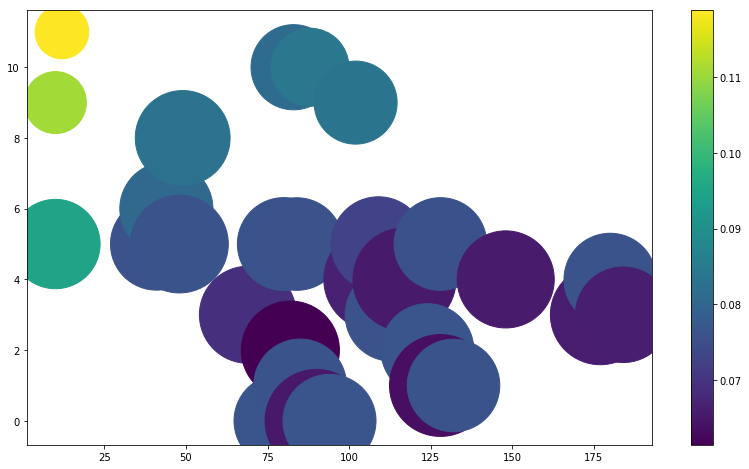

In [8]:
print(Runs[Runs['MSE'] == Runs['MSE'].min()])
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()

CH4 Results: 
    
      MSE     N     STD     T
12  0.233444  23  0.031446  0

CH4 Results:

         MSE   N      STD  T
10  0.061422  82  0.01039  2